In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter
from scipy.stats import entropy

import random
from math import ceil

import warnings

In [ ]:
sns.set_style("white")
sns.set(rc={'figure.figsize':(10,5)})
warnings.filterwarnings('ignore')

In [ ]:
from VTDA.utils.training_dynamics.utils import scatter_it,plot_labeled

### Preparing Data

In [ ]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [ ]:
##classes in dataset 0=T-shirt ...
classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

###AUM

In [ ]:
from VTDA.utils.training_dynamics.AreaUnderTheMarginRanking import AreaUnderTheMarginRanking

###Our Class

In [ ]:
from VTDA.utils.training_dynamics.TrainingDynamics import TrainingDynamics

In [ ]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


###Model

In [ ]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
deneme = TrainingDynamics(training_data,100,classes,'cpu')

### Train Function

In [ ]:
def train(dataloader, model, loss_fn, optimizer):

  size = len(dataloader.dataset)
  model.train()

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # Compute prediction error
    pred = model(X)

    #### Prediction History - Our Class
    deneme.batch_accumulate(pred,batch,y)

    ##Calculate LOSS
    loss = loss_fn(pred, y)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 100 == 0:
        loss, current = loss.item(), batch * len(X)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


  ### add prediction history of this epoch to full history
  deneme.epoch_accumulate()

### Test Function

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

###Training & Evaluating Model

In [ ]:
epochs = 50

TrainingDynamicsViz=TrainingDynamics(training_data,epochs,len(train_dataloader.dataset),classes, device)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)

TrainingDynamicsViz.calculate()

print("Done!")

In [ ]:
model.eval()
x, y = test_data[0][0], test_data[0][1]

if device =="cuda":
  x=x.to(device)

with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


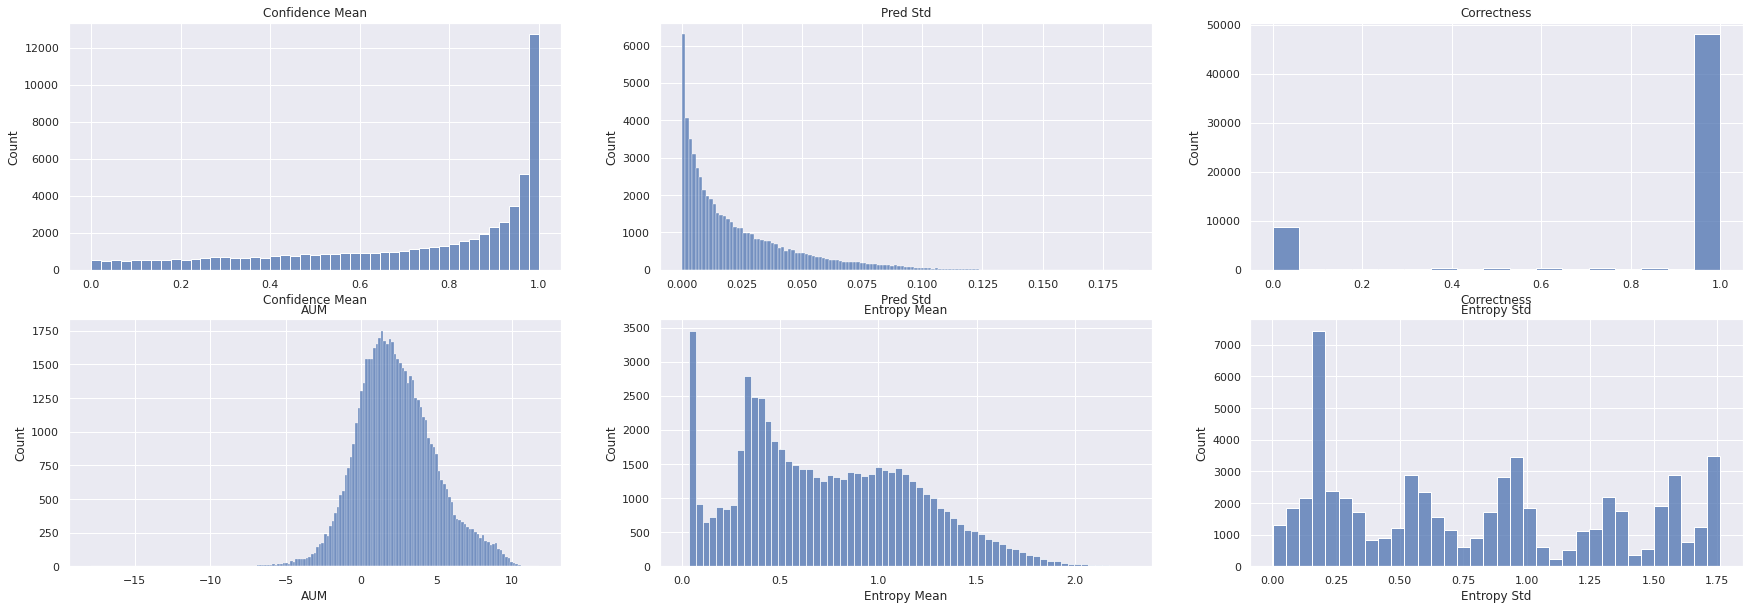

In [ ]:
TrainingDynamicsViz.plot_dist()

### Data Cartography

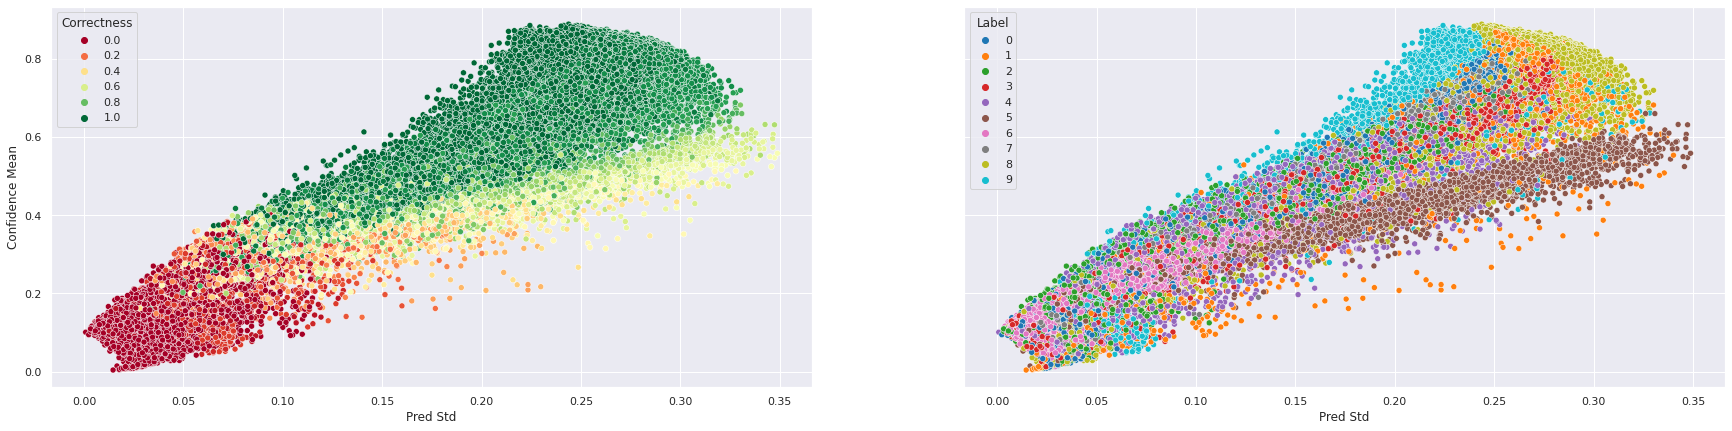

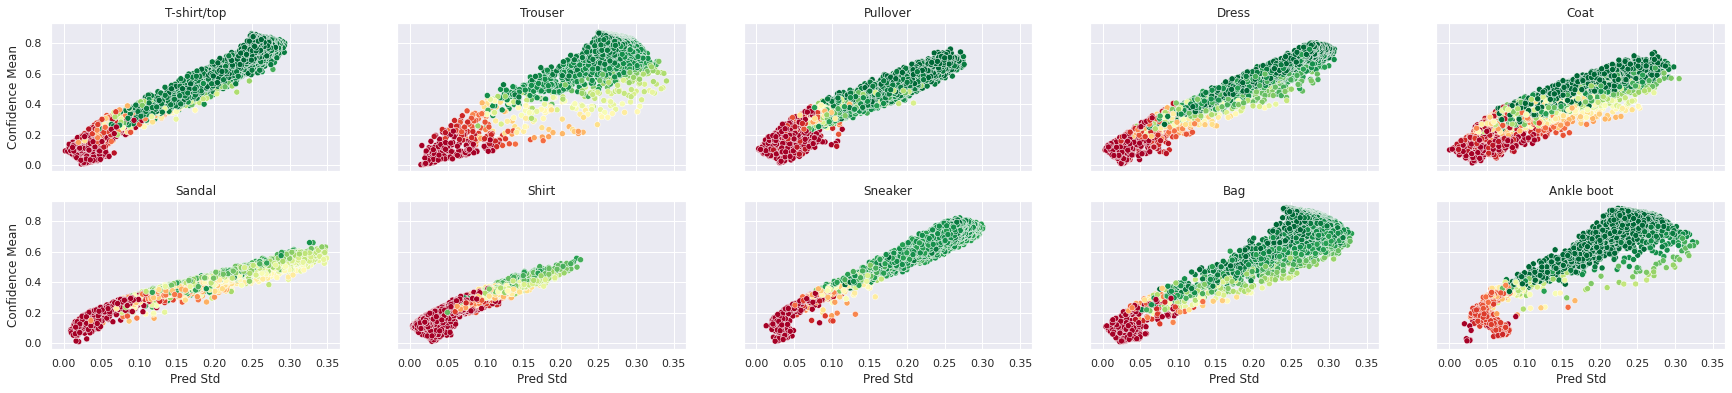

In [ ]:
TrainingDynamicsViz.plot_maps()

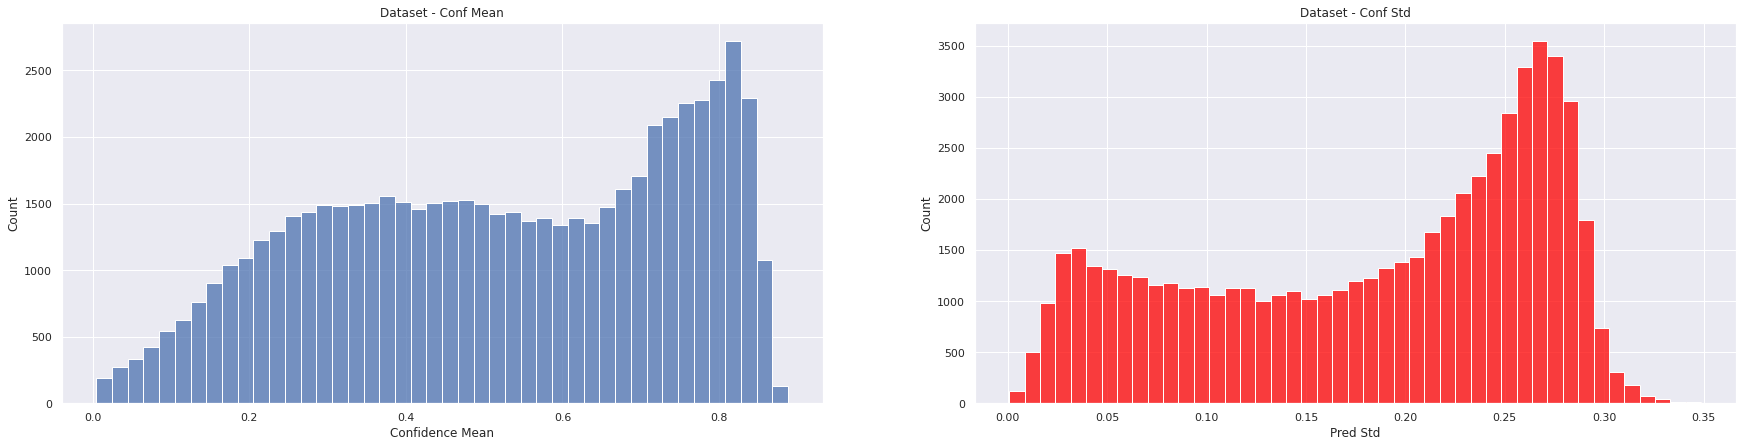

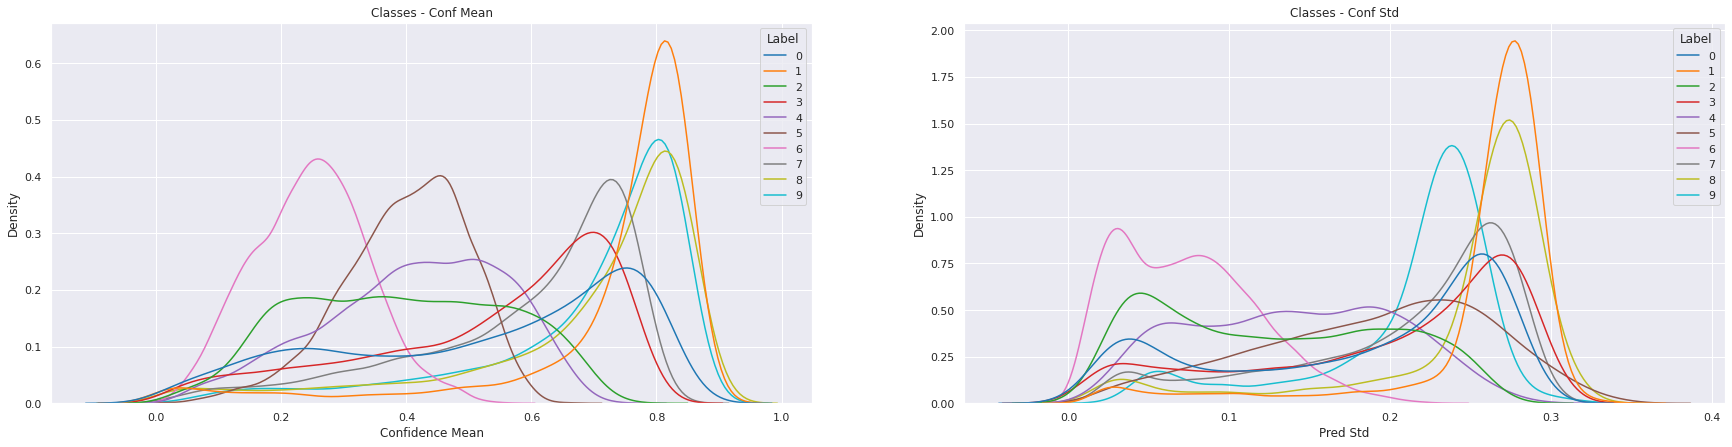

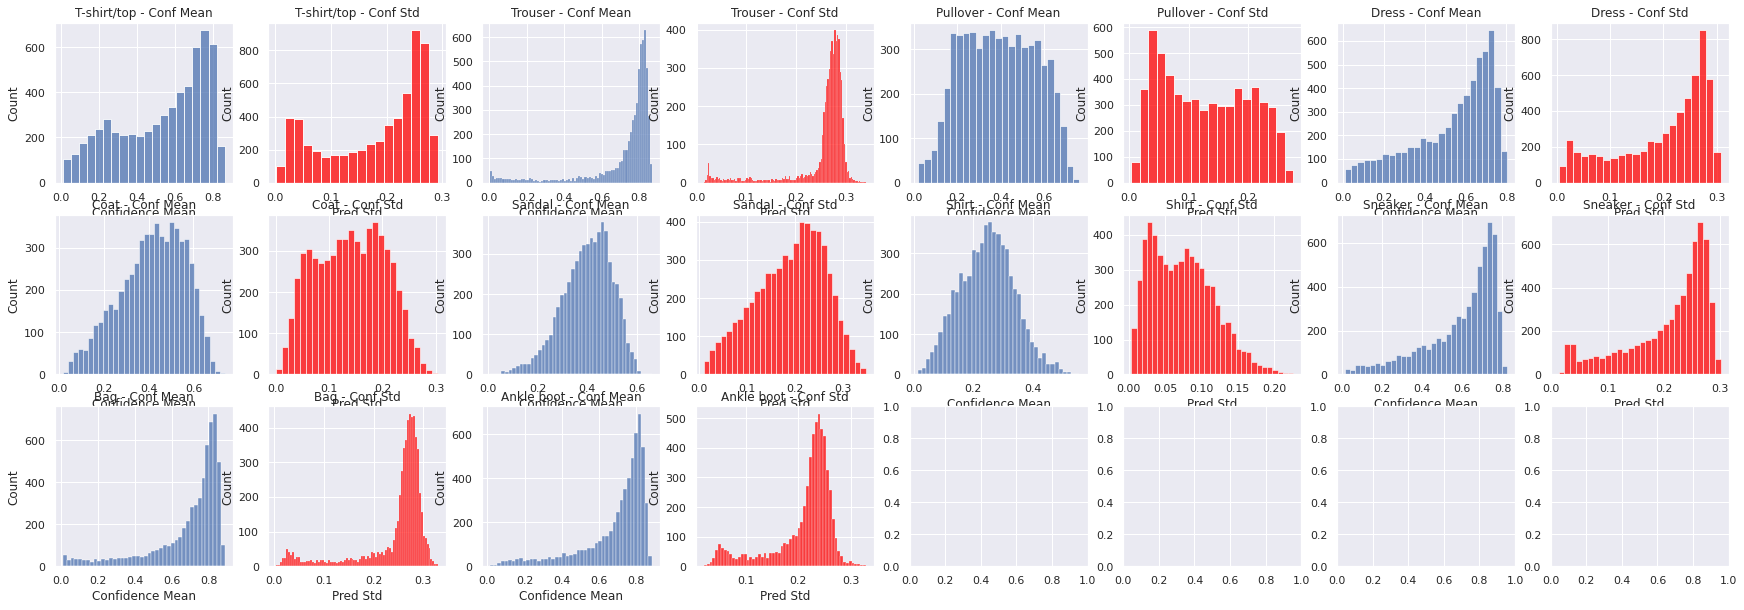

In [ ]:
TrainingDynamicsViz.plot_mean_std()

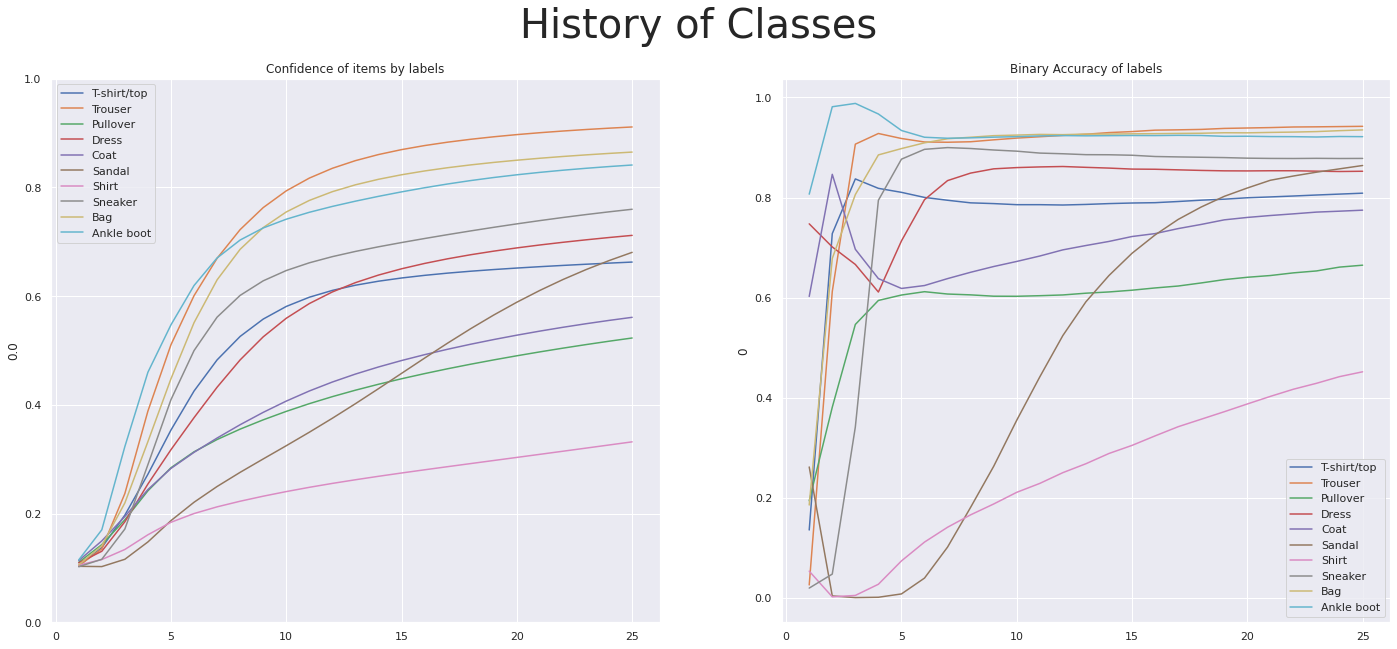

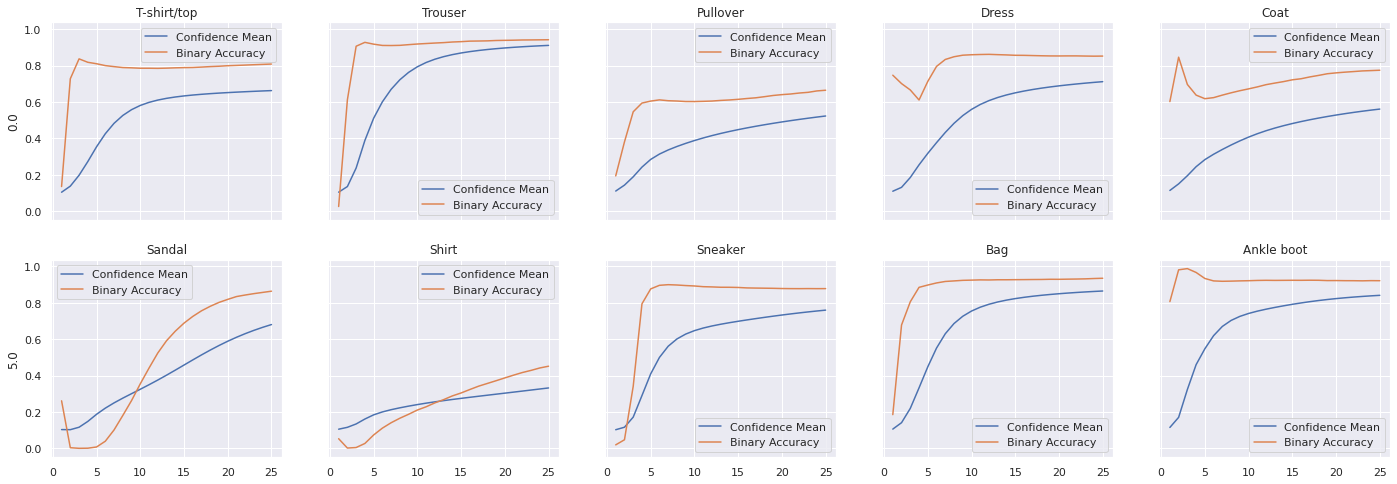

In [ ]:
TrainingDynamicsViz.plot_accuracy()

###AUM

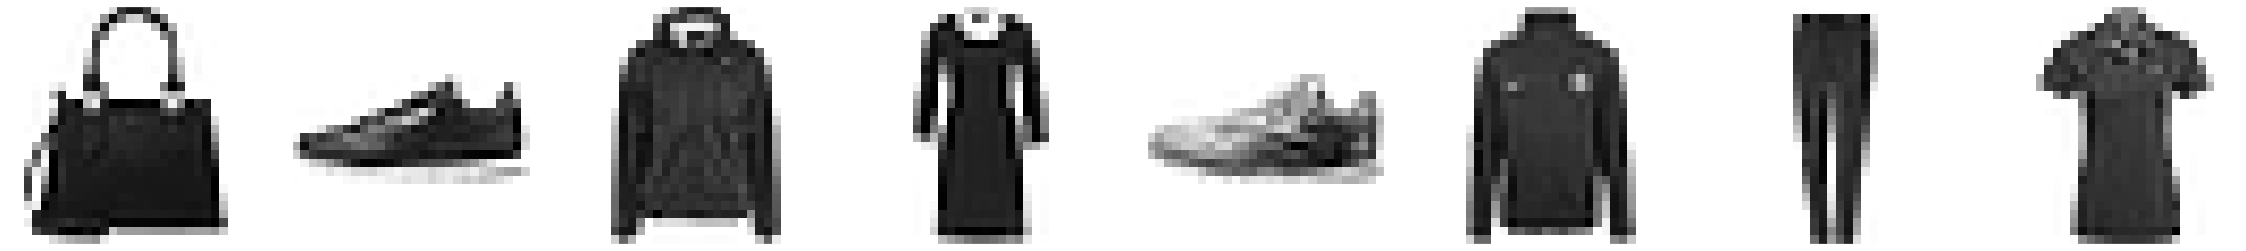

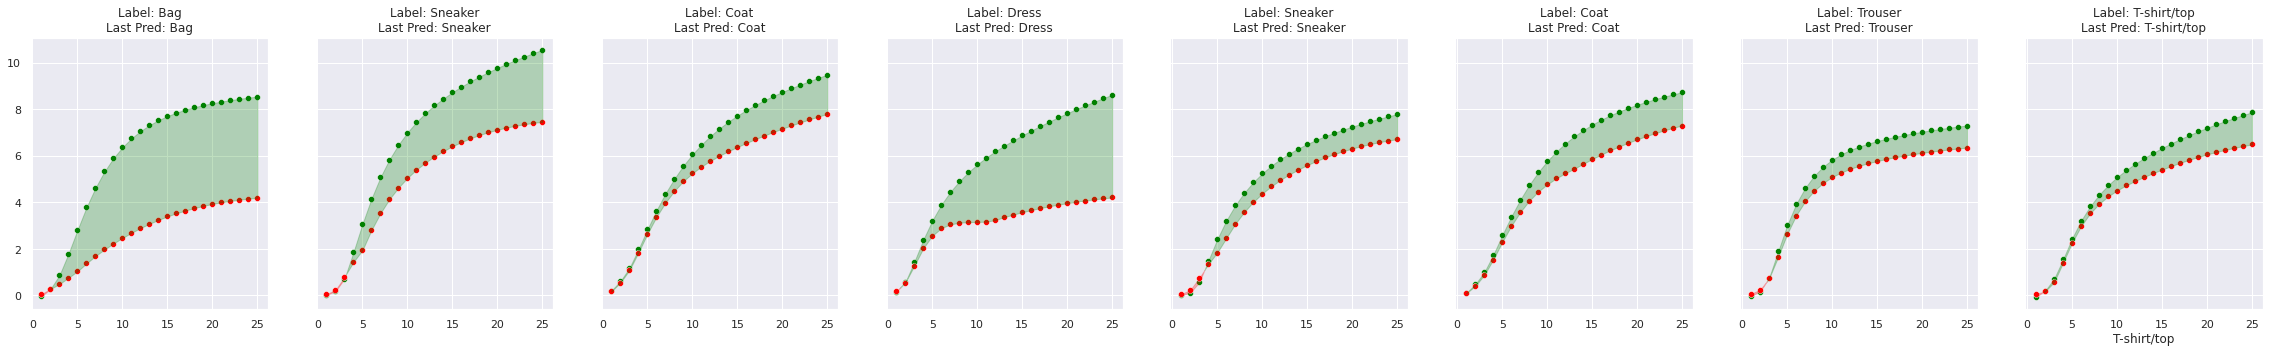

In [ ]:
TrainingDynamicsViz.plot_aum()

###Forgetting

In [ ]:
targets = training_data.targets.cpu().numpy()
df = pd.DataFrame(targets, columns=["Label"])

In [ ]:
print("Total forgets during training= ",df["Forget Nums"].sum())
print("Total forgotten instances during training= ",(df["Forget Nums"]!=0).sum())

Total forgets during training=  9317
Total forgotten instances during training=  8751


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density e

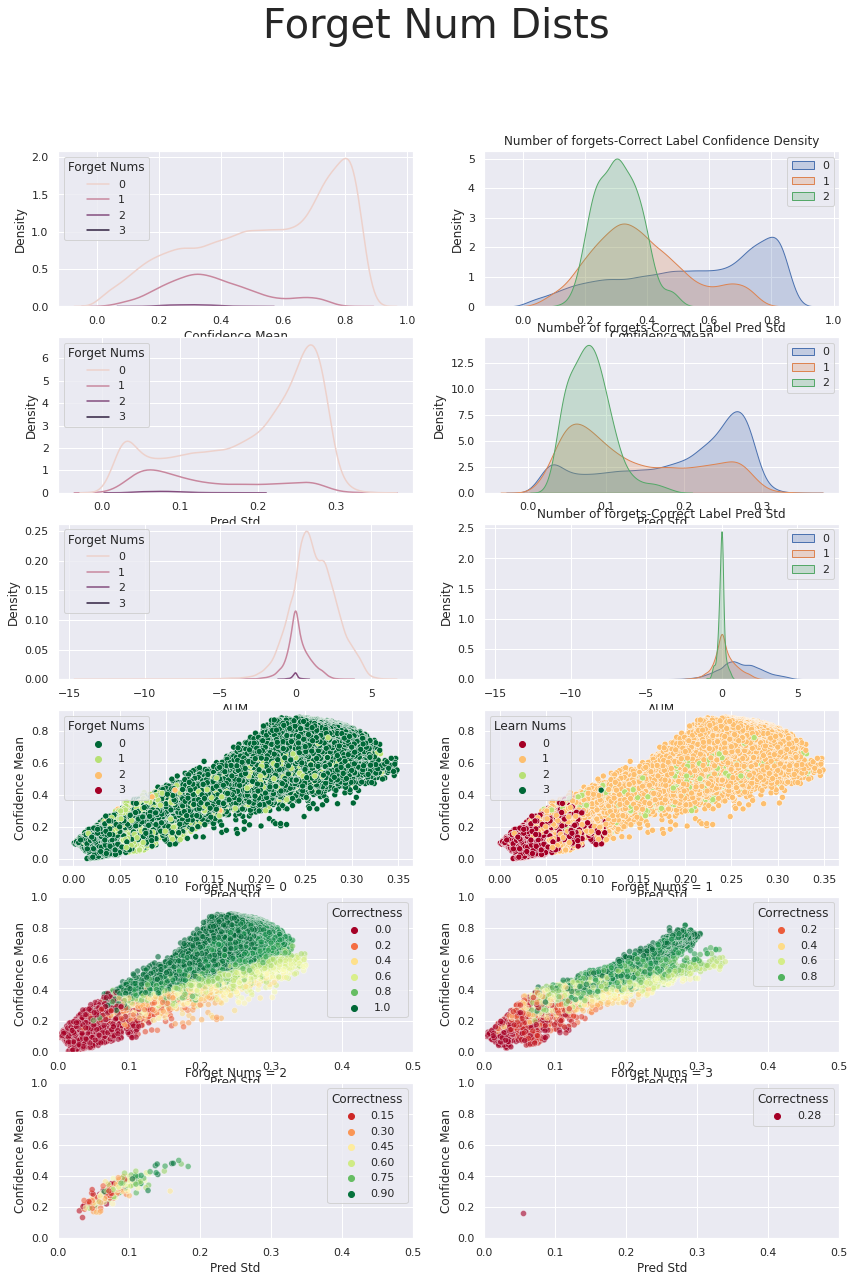

In [ ]:
TrainingDynamicsViz.plot_forgets()

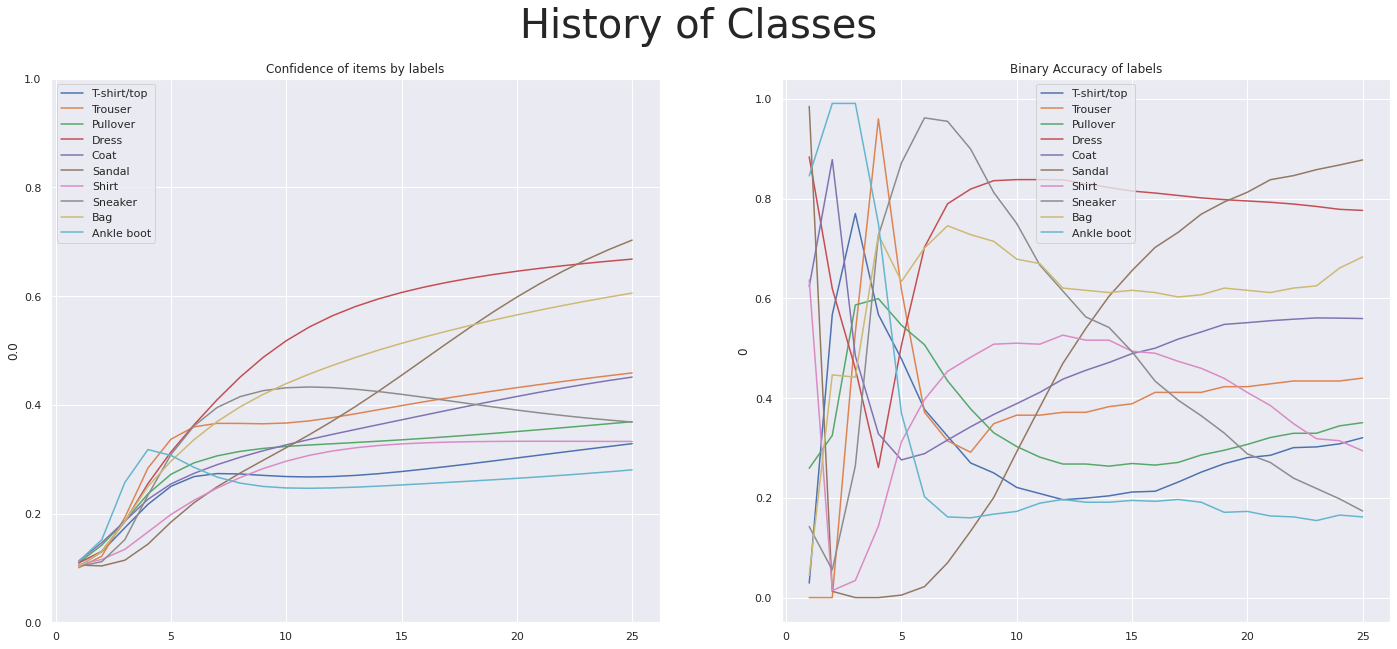

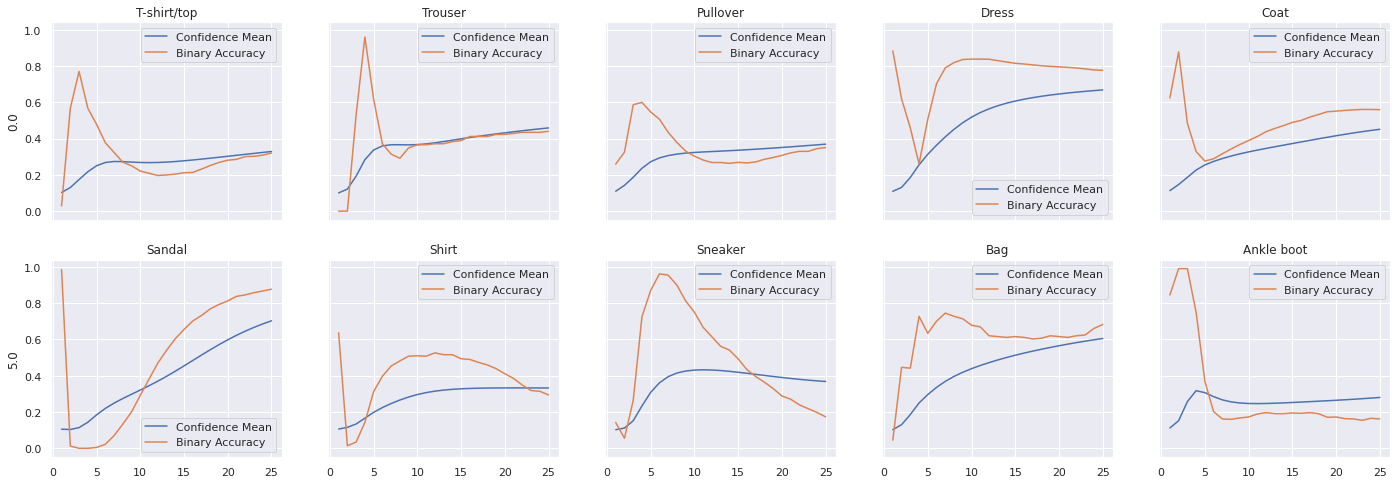

In [ ]:
TrainingDynamicsViz.plot_accuracy(forgets=True)

#### distribution of forget events to epochs

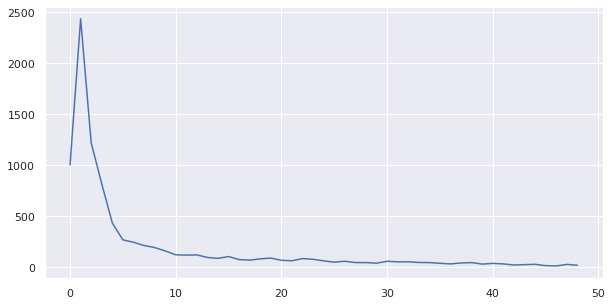

In [ ]:
sns.lineplot(data=forgots_in_epoch.sum(axis=0)) #### didnt include yet

### ENTROPY

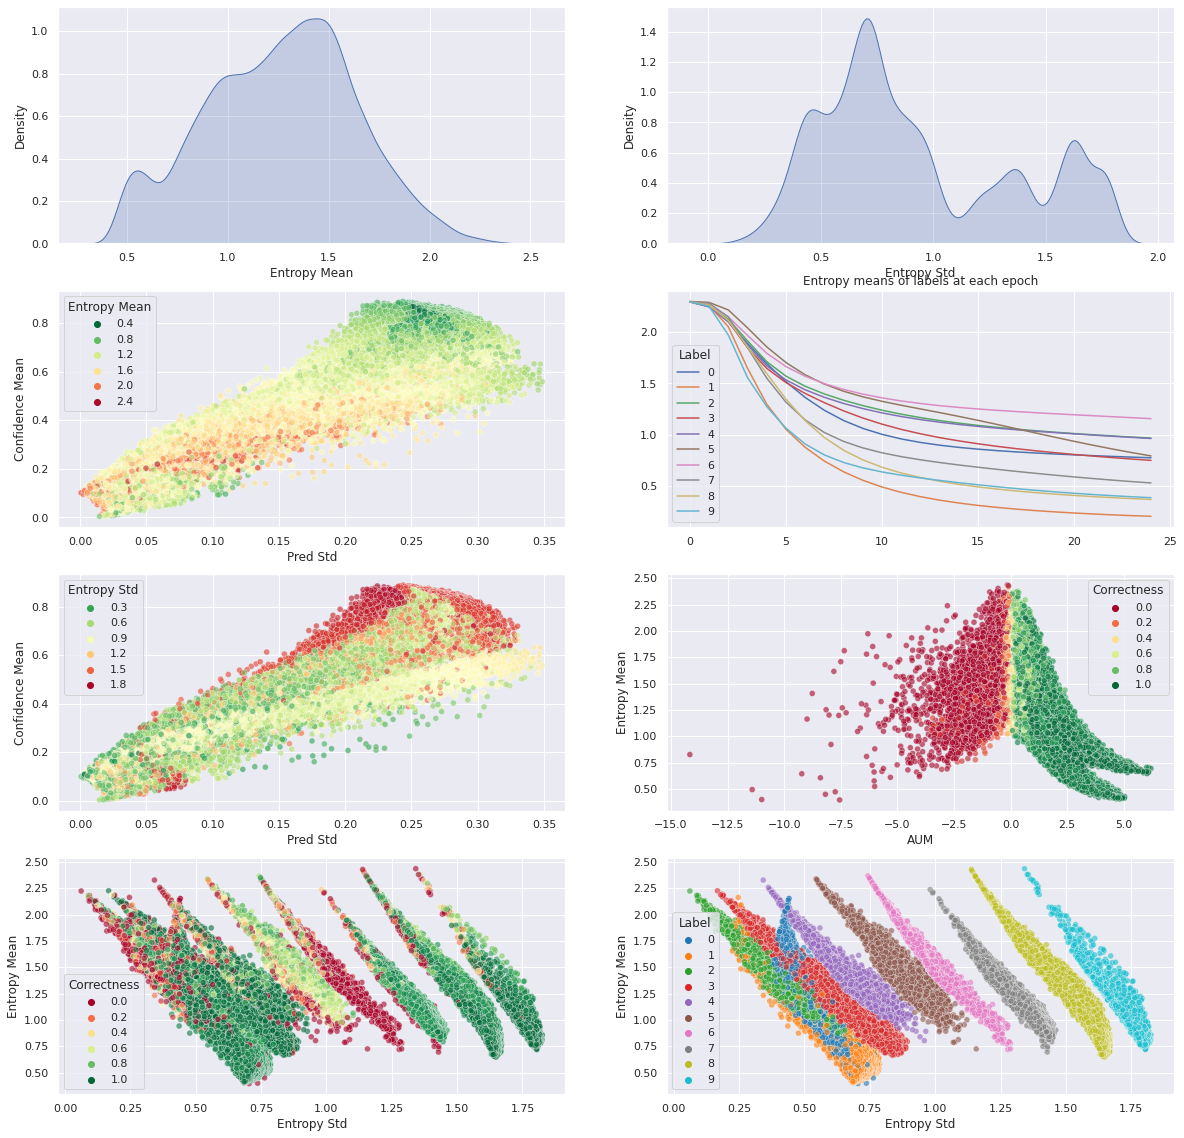

In [ ]:
TrainingDynamicsViz.plot_entropy()

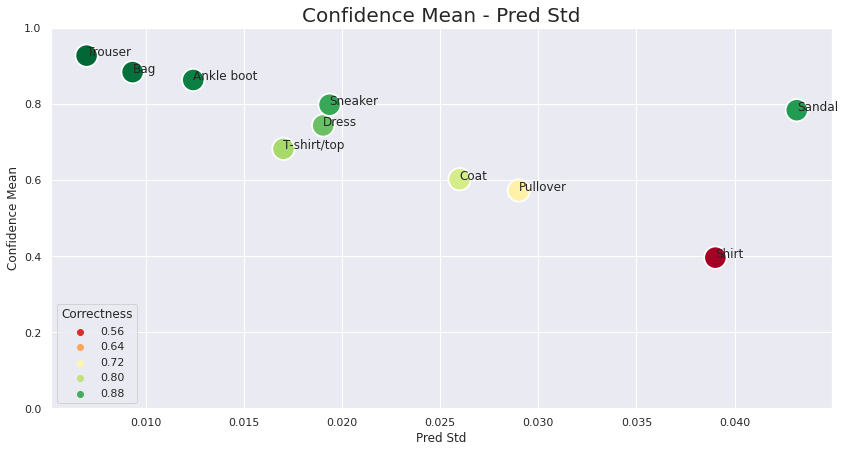

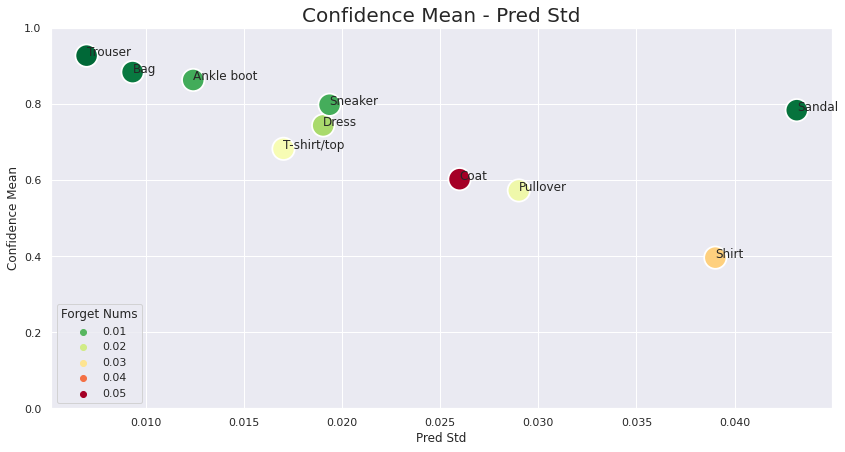

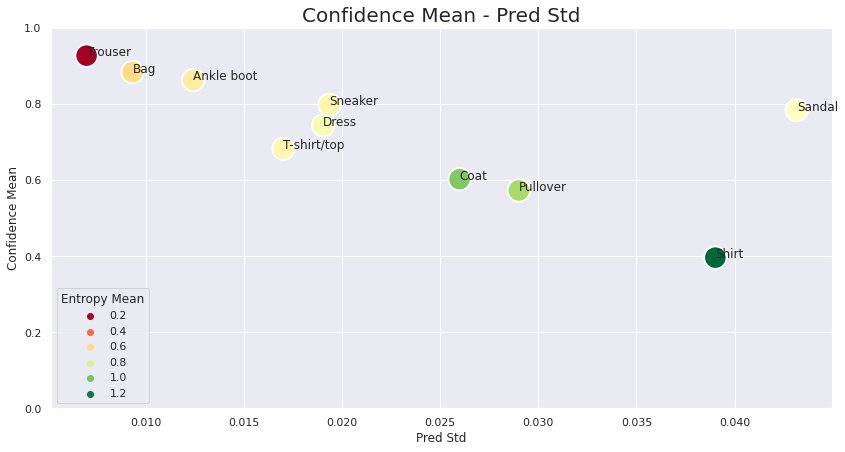

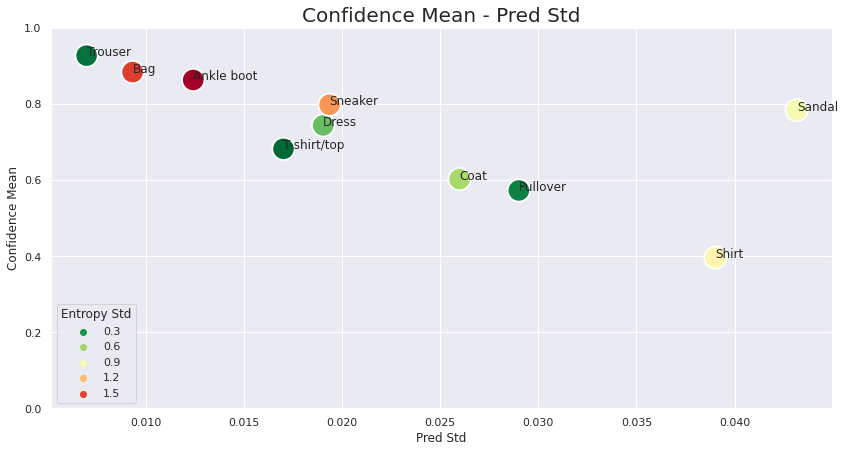

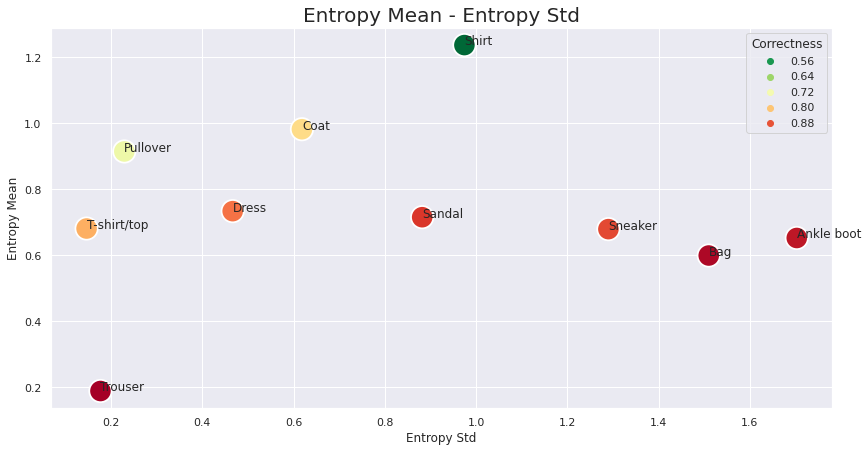

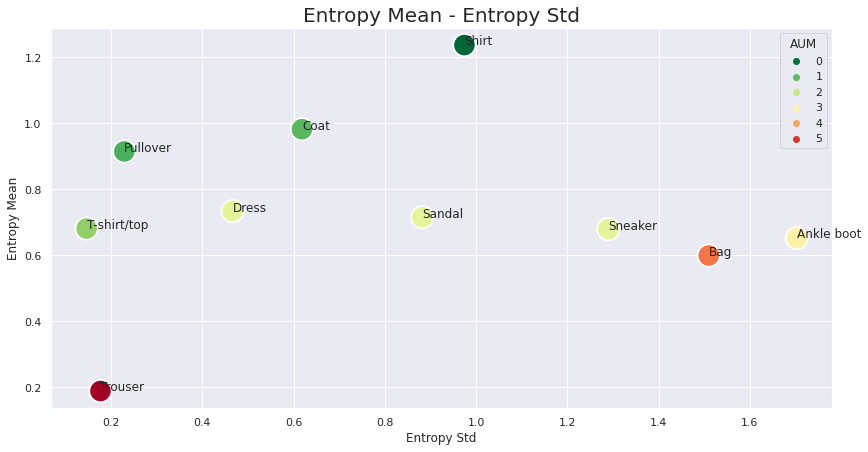

In [ ]:
TrainingDynamicsViz.plot_classmaps()

###Last Status

In [ ]:
deneme.df.head()

Label  Confidence Mean  Pred Std  Last Pred  Last Pred Corr  Correctness  \
0      9         0.767684  0.245161          9            True         0.96   
1      0         0.787049  0.289084          0            True         0.96   
2      0         0.123912  0.021874          1           False         0.00   
3      3         0.172660  0.036534          0           False         0.00   
4      0         0.084141  0.045514          3           False         0.00   

        AUM  Forget Nums  Learn Nums  Entropy Mean  Entropy Std  
0  2.077778            0           1      1.051646     1.738942  
1  2.634230            0           1      0.637655     0.753490  
2 -0.913636            0           0      1.595292     0.426285  
3 -0.703081            0           0      1.725402     0.362430  
4 -2.007753            0           0      1.027366     0.576040

###Linear regression trial

In [ ]:
num_pred_hist.shape

(50, 60000, 10)

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
reg_df=pd.DataFrame(columns=["Coeff","Intercept"])
correct_label_prediction = np.take_along_axis( num_pred_hist, np.atleast_3d(targets),axis=2).squeeze().transpose()

In [ ]:
for i in range(targets.shape[0]): ## this takes a alot of timne
  model=LinearRegression()
  model.fit(np.arange(1,epochs+1).reshape(-1,1), correct_label_prediction[i])
  reg_df.loc[i]=[model.coef_[0],model.intercept_]
  if i%1024 == 0:
    print(i)

In [ ]:
df["Coeff"]=reg_df["Coeff"]*100
df["Intercept"]=reg_df["Intercept"]

In [ ]:
df.head()

Label  Confidence Mean  Pred Std  Last Pred  Last Pred Corr  Correctness  \
0      9         0.874724  0.206538          9            True         1.00   
1      0         0.879865  0.223541          0            True         0.98   
2      0         0.138368  0.028128          3           False         0.02   
3      3         0.179952  0.025941          0           False         0.00   
4      0         0.086293  0.030527          3           False         0.04   

        AUM  Forget Nums  Learn Nums  Entropy Mean  Entropy Std     Coeff  \
0  3.370574            0           1      0.580765     1.324561  1.021605   
1  3.201410            0           1      0.393267     0.597735  0.979059   
2 -0.836646            1           1      1.622276     0.300896  0.128616   
3 -0.862388            0           0      1.562412     0.310025  0.067469   
4 -2.068392            1           1      0.911163     0.415993 -0.061069   

   Intercept  
0   0.614215  
1   0.630205  
2   0.105571  
3   0.162748  
4   0.101866

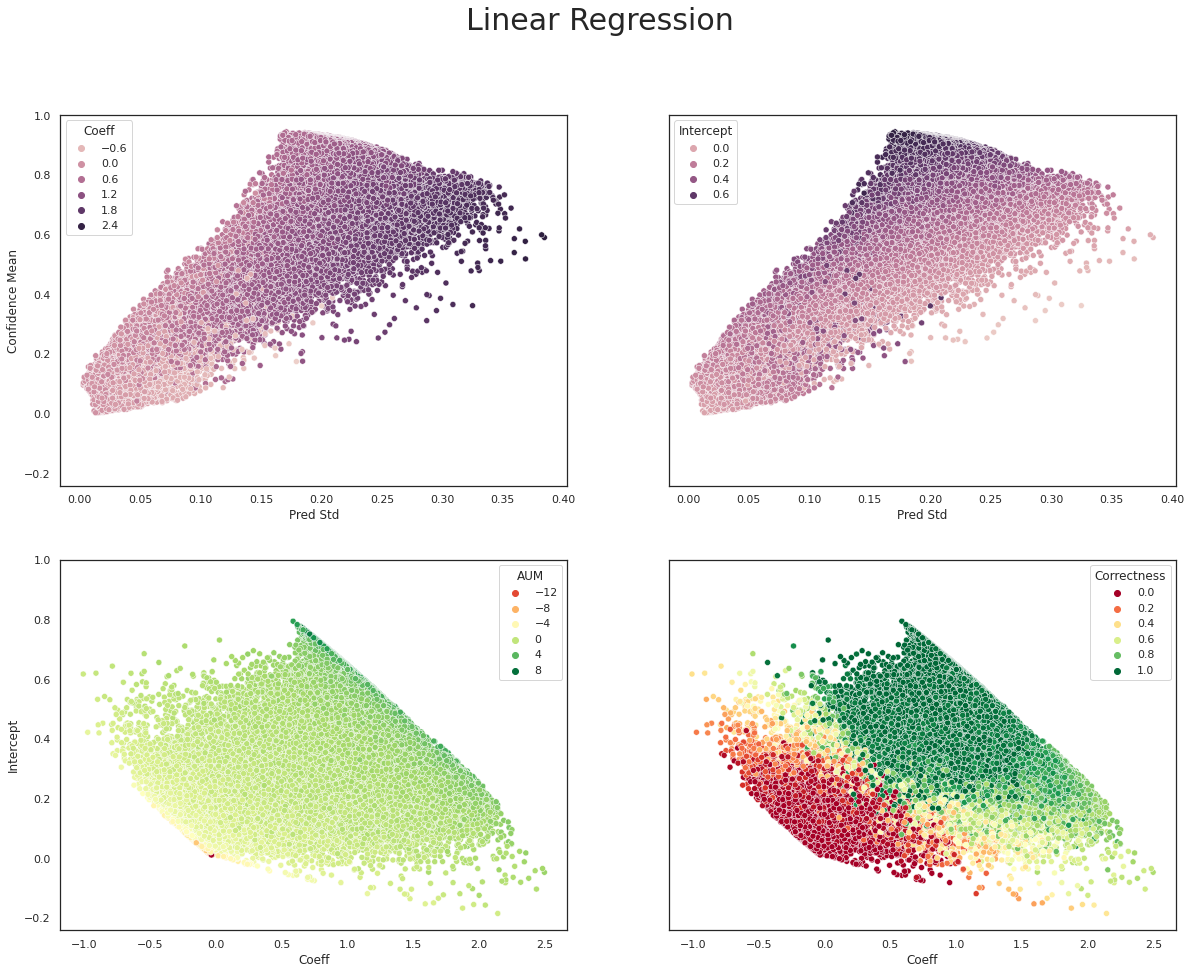

In [ ]:
fig, axes = plt.subplots(2 , 2, figsize=(20, 15),sharey=True)
fig.suptitle("Linear Regression",size=30)
sns.scatterplot(ax=axes[0,0],data=df,x="Pred Std",y="Confidence Mean",hue="Coeff")
sns.scatterplot(ax=axes[0,1],data=df,x="Pred Std",y="Confidence Mean",hue="Intercept")
sns.scatterplot(ax=axes[1,0],data=df,x="Coeff",y="Intercept",hue="AUM",palette="RdYlGn")
sns.scatterplot(ax=axes[1,1],data=df,x="Coeff",y="Intercept",hue="Correctness",palette="RdYlGn")

### My Index

In [ ]:
df["My Index"]=df["Confidence Mean"]- (correct_label_prediction[:,49]-correct_label_prediction[:,0])/2

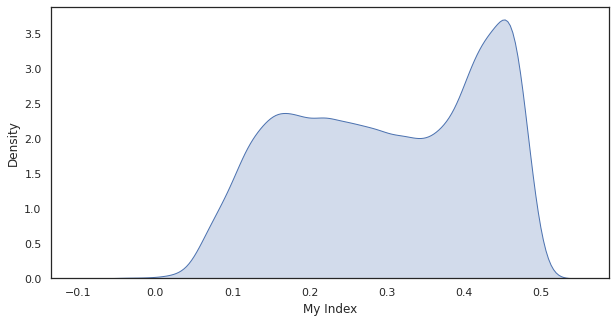

In [ ]:
sns.kdeplot(df["My Index"],shade=True)

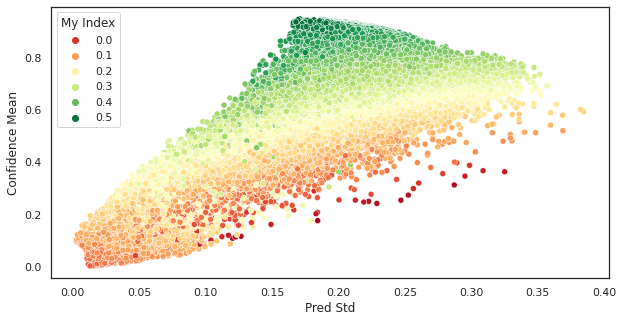

In [ ]:
sns.scatterplot(data=df,y="Confidence Mean",x="Pred Std",hue="My Index",palette="RdYlGn")

#Not Important much

### Confidence Learning // You can Skip

In [ ]:
!pip install cleanlab

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 95 kB 4.7 MB/s 


In [ ]:
import requests
import io
import cleanlab
from cleanlab.filter import find_label_issues

#### Health Summary

In [ ]:
cleanlab.dataset.health_summary(targets, num_pred_hist[-1], class_names=classes)

------------------------------------------------------------
|  Generating a Cleanlab Dataset Health Summary            |
|   for your dataset with 60,000 examples and 10 classes.  |
|  Note, Cleanlab is not a medical doctor... yet.          |
------------------------------------------------------------

Overall Class Quality and Noise across your dataset (below)
------------------------------------------------------------ 



Class Name  Class Index  Label Issues  Inverse Label Issues  Label Noise  \
0        Shirt            6          1547                  1905     0.257833   
1     Pullover            2          1168                   932     0.194667   
2         Coat            4           933                  1076     0.155500   
3  T-shirt/top            0           704                   663     0.117333   
4        Dress            3           311                   280     0.051833   
5          Bag            8           174                    86     0.029000   
6      Trouser            1           122                     7     0.020333   
7       Sandal            5           118                    53     0.019667   
8   Ankle boot            9           113                   104     0.018833   
9      Sneaker            7           107                   191     0.017833   

   Inverse Label Noise  Label Quality Score  
0             0.299623             0.742167  
1             0.161693             0.805333  
2             0.175159             0.844500  
3             0.111260             0.882667  
4             0.046909             0.948167  
5             0.014547             0.971000  
6             0.001189             0.979667  
7             0.008930             0.980333  
8             0.017359             0.981167  
9             0.031394             0.982167


Class Overlap. In some cases, you may want to merge classes in the top rows (below)
-----------------------------------------------------------------------------------



Class Name A Class Name B  Class Index A  Class Index B  \
0   T-shirt/top        Shirt              0              6   
1      Pullover        Shirt              2              6   
2          Coat        Shirt              4              6   
3      Pullover         Coat              2              4   
4         Dress         Coat              3              4   
5       Sneaker   Ankle boot              7              9   
6         Shirt          Bag              6              8   
7         Dress        Shirt              3              6   
8   T-shirt/top        Dress              0              3   
9        Sandal      Sneaker              5              7   
10      Trouser        Dress              1              3   
11  T-shirt/top     Pullover              0              2   
12       Sandal   Ankle boot              5              9   
13  T-shirt/top          Bag              0              8   
14      Trouser     Pullover              1              2   
15     Pullover          Bag              2              8   
16     Pullover        Dress              2              3   
17      Sneaker          Bag              7              8   
18  T-shirt/top         Coat              0              4   
19         Coat          Bag              4              8   
20      Trouser        Shirt              1              6   
21        Dress          Bag              3              8   
22       Sandal          Bag              5              8   
23      Trouser         Coat              1              4   
24      Trouser          Bag              1              8   
25     Pullover       Sandal              2              5   
26        Shirt   Ankle boot              6              9   
27  T-shirt/top       Sandal              0              5   
28         Coat      Sneaker              4              7   
29       Sandal        Shirt              5              6   
30         Coat   Ankle boot              4              9   
31        Shirt      Sneaker              6              7   
32  T-shirt/top      Trouser              0              1   
33         Coat       Sandal              4              5   
34        Dress   Ankle boot              3              9   
35        Dress      Sneaker              3              7   
36        Dress       Sandal              3              5   
37     Pullover   Ankle boot              2              9   
38     Pullover      Sneaker              2              7   
39      Trouser   Ankle boot              1              9   
40      Trouser      Sneaker              1              7   
41      Trouser       Sandal              1              5   
42  T-shirt/top   Ankle boot              0              9   
43  T-shirt/top      Sneaker              0              7   
44          Bag   Ankle boot              8              9   

    Num Overlapping Examples  Joint Probability  
0                       1107           0.018450  
1                       1097           0.018283  
2                        926           0.015433  
3                        862           0.014367  
4                        189           0.003150  
5                        168           0.002800  
6                        157           0.002617  
7                        153           0.002550  
8                        143           0.002383  
9                        115           0.001917  
10                        79           0.001317  
11                        63           0.001050  
12                        48           0.000800  
13                        38           0.000633  
14                        35           0.000583  
15                        22           0.000367  
16                        20           0.000333  
17                        15           0.000250  
18                        15           0.000250  
19                        14           0.000233  
20                        11           0.000183  
21                         7           0.000117  



 * Overall, about 9% (5,297 of the 60,000) labels in your dataset have potential issues.
 ** The overall label health score for this dataset is: 0.91.

Generated with <3 from Cleanlab.



{'overall_label_health_score': 0.9117166666666665,
 'joint': array([[8.82666667e-02, 0.00000000e+00, 7.33333333e-04, 1.23333333e-03,
         2.00000000e-04, 1.66666667e-05, 9.00000000e-03, 0.00000000e+00,
         5.50000000e-04, 0.00000000e+00],
        [0.00000000e+00, 9.79666667e-02, 5.83333333e-04, 1.21666667e-03,
         5.00000000e-05, 0.00000000e+00, 1.66666667e-04, 0.00000000e+00,
         1.66666667e-05, 0.00000000e+00],
        [3.16666667e-04, 0.00000000e+00, 8.05333333e-02, 2.00000000e-04,
         9.40000000e-03, 1.66666667e-05, 9.33333333e-03, 0.00000000e+00,
         2.00000000e-04, 0.00000000e+00],
        [1.15000000e-03, 1.00000000e-04, 1.33333333e-04, 9.48166667e-02,
         1.90000000e-03, 0.00000000e+00, 1.90000000e-03, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00],
        [5.00000000e-05, 0.00000000e+00, 4.96666667e-03, 1.25000000e-03,
         8.44500000e-02, 0.00000000e+00, 9.16666667e-03, 0.00000000e+00,
         1.16666667e-04, 0.00000000e+00],


####Label Scoring

In [ ]:
issues = find_label_issues(labels=targets, pred_probs=num_pred_hist[-1]) ###pred should be updated after cross validation supplied to code !!!!!!
print(issues)

[False False False ... False False False]


In [ ]:
plot_examples(issues[range(15)], 3, 5)

NameError: ignored

####Plot Founded Label Issues

In [ ]:
## plot founded label issues
plt.figure(figsize=(10,10))
for i in range(50,75):
  plt.subplot(5,5,i-49)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(training_data.data[issues][i], cmap=plt.cm.binary)
  plt.xlabel(classes[targets[issues][i]])
plt.show()

####Overlapping Classess

In [ ]:
import graph_tool as gt

In [ ]:
##Overlapping Classes
overlaps=cleanlab.dataset.find_overlapping_classes(
    labels=targets, 
    class_names=classes,
    pred_probs=num_pred_hist[-1])

overlaps["Joint Probability%"]=overlaps["Joint Probability"]*100

In [ ]:
vals = np.unique(overlaps[['Class Name A', 'Class Name B']])
overlap_adj=overlaps.pivot(index='Class Name A', columns='Class Name B', values='Joint Probability%').reindex(columns=vals, index=vals, fill_value=0).fillna(0)
overlap_adj+=overlap_adj.transpose()

In [ ]:
overlap_adj.sum(axis=1)

In [ ]:
fig, ax = plt.subplots(figsize=(14,14)) 
ax=sns.heatmap(overlap_adj,annot=True,vmin=0,vmax=5, fmt='g',cmap="Reds",linewidths=2)
ax.set_title('Joint Probability%',)
ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')
plt.xticks(rotation = 0)
plt.yticks(rotation = 0)

##clustering

In [ ]:
df.head()

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
kmeans = KMeans(n_clusters = 3, random_state = 0)
df["clusters"] = kmeans.fit_predict(df)

In [ ]:
sns.set(rc={'figure.figsize':(14,7)})
sns.scatterplot(data=df, x="std", y="Confidence Mean", hue="clusters", palette="deep")